# Defining the VRP Hamiltonian

In [1]:
!pip install cplex

In [2]:
%run -i Hamiltonian_provider.py

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In this example, we are going to test the filtering VQE with an instance of the vehicule routing problem with 6 qubits (so that we can run it on the OSLO quantum hardware with 7 qubits).

In [3]:
### Problem definition
n= 3 # number of nodes + depot (n+1)
K= 2 # number of vehicles
b= 0
H, offset=Hamilton(n,K,b)

In [4]:
print(H)

78572.82126291405 * IIIIIZ
+ 78331.99410854303 * IIIIZI
+ 78572.82126291405 * IIIZII
- 393.2104562109598 * IIZIII
+ 78331.99410854303 * IZIIII
- 393.2104562109598 * ZIIIII
+ 39321.0456210975 * IIIIZZ
+ 39321.0456210975 * IIZIZI
+ 39321.0456210975 * IIZZII
+ 39321.0456210975 * IZIZII
+ 39321.0456210975 * ZIIIIZ
+ 39321.0456210975 * ZZIIII


# [Filtering variational quantum algorithms for combinatorial optimization](https://arxiv.org/abs/2106.10055) (Implementation using Qiskit library)

Warning: This code uses a filtering operator that was introduced in the first version of the paper. The other filtering operators are in construction (this notebook will be updated later)...

* The filtering operator: $c1-H$ where $c\geq E_{max}$  , $E_{max}$ is the maximum eigenvalue of the $Hamiltonian$

* The filtering function: $c-E$ where $c\geq E_{max}$

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import isclose
from qiskit import QuantumCircuit, execute, Aer
from scipy.optimize import minimize
from qiskit.opflow import I, X, Z, Y
import itertools
from qiskit.algorithms.optimizers import GradientDescent #,ADAM, CG, GSLS, NELDER_MEAD, NFT, POWELL, SPSA, TNC, COBYLA, L_BFGS_B, SLSQP, AQGD, P_BFGS
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, execute, transpile, Aer, assemble
from qiskit.tools.monitor import job_monitor

In [6]:
def Ansatz(theta,n,l=1):
    m=0
    q=QuantumCircuit(n)
    for i in range(n):
        q.ry(theta[i],i)
        m+=1
    
    for _ in range(l):
        if (n % 2) == 0:
            #Sub Layer1

            for i, j in itertools.zip_longest(range(0,n-1,2), range(0,n,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1
        #=========================
            #Sub Layer2

            for i, j in itertools.zip_longest(range(1,n-2,2), range(1,n-1,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1
        else:
            #SubLayer1

            for i, j in itertools.zip_longest(range(0,n-1,2), range(0,n-1,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1
            #==========================
            #SubLayer2

            for i, j in itertools.zip_longest(range(1,n-1,2), range(1,n,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1

    return q

In [7]:
def filtering_function6(E, c):
    return (c-E)

# Defining the functions to be utilized to solve our problem

In [8]:
# A function to return the eigenvalue if the Pauli Z matrix depending on a binary state e.g. 1101
def sign(measure,index):
    if not index:
        return 1
    measure=np.array(list(measure))
    p=1
    for b in measure[index]:
        p=p*(-1)**int(b)
    return p
# A function that returns the count of an executed experiment.
def count(theta,n,l,shots, hardware=False):
    
    circuit = Ansatz(theta,n,l)
    circuit.measure_all()
    
    if hardware==True:# & already_run==False:
        IBMQ.save_account("your API", overwrite=True) 
        provider = IBMQ.load_account()

        provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
        backend = provider.get_backend('ibm_oslo')

        # prepare the circuit for the backend
        mapped_circuit = transpile(circuit, backend=backend)
        qobj = assemble(mapped_circuit, backend=backend, shots=1024)

        # execute the circuit
        job = backend.run(qobj)
        job.status()
        jobid=job.job_id()
        job = provider.get_backend('ibm_oslo').retrieve_job(jobid)
        result = job.result()
        counts = result.get_counts()
    # elif hardware==True & already_run==False:
    #     job = provider.get_backend('ibm_oslo').retrieve_job(jobid)
    #     result = job.result()
    #     counts = result.get_counts()
        
    else:
    
        backend = Aer.get_backend('qasm_simulator')
        job = execute(circuit, backend, shots=shots)
        result = job.result()
        counts = result.get_counts()
    return counts
# A function that returns the expected value of a given filtering operator (or an operator in general)
def expectation(theta,n,l,H,shots,tau,filtering,power,hardware):
    counts_dict=count(theta,n,l,shots,hardware)
    energies,probabilities=[],[]
    for stri,proba in counts_dict.items():
        sums=0
        for i, coef in enumerate(H.coeffs):
            weight = np.real(coef)
            indices = np.where(H.primitive.table.Z[i])
            sums += weight * sign(stri,indices)
        energies.append(sums)
        probabilities.append(proba)
###########

    F_exp=0
    for i in range(len(energies)):
        if filtering ==True:
            if power==True:
                F_exp+=(probabilities[i]*filtering_function6(energies[i], tau)**2)
            else:
                F_exp+=(probabilities[i]*filtering_function6(energies[i], tau))
        else:
            F_exp+=(probabilities[i]*energies[i])
    if isclose(1.0, sum(probabilities), rel_tol=1e-1, abs_tol=0.0)==False:
        F_exp=F_exp/shots
    
    return F_exp

# Note:

* `theta`: are the parameters that will be injected in the parametrized circuit

* `n`: are the number of qubits

* `l`: is the number of layers in our ansatz

* `H`: is the Hamiltonian that we want to compute its lower energy

* `shots`: total number of samples

* `tho`: is the hyperparameter existing in each filtering operator. In this notebook $\tau = c$ for the case of the `filtering_function6`

* `filtering`: determine whether you want to apply the filtering function to the sampled energies

* `power`: determine whether you want to raise the filtering function to the power of 2

In [9]:
def usual_expectation(n,l,H,shots,hardware):
    def sub_usual_expectation(theta):
        counts_dict=count(theta,n,l,shots,hardware)
        
        energies,probabilities=[],[]
        for stri,proba in counts_dict.items():
            sums=0
            for i, coef in enumerate(H.coeffs):
                weight = np.real(coef)
                indices = np.where(H.primitive.table.Z[i])
                sums += weight * sign(stri,indices)
            energies.append(sums)
            probabilities.append(proba)
    
    
        F_exp=0
        for i in range(len(energies)):
            F_exp+=(probabilities[i]*energies[i])
        if isclose(1.0, sum(probabilities), rel_tol=1e-1, abs_tol=0.0)==False:
            F_exp=F_exp/shots
        
        return F_exp
    return sub_usual_expectation

***

Defining the gradient: $$
\left.\frac{\partial \mathcal{C}_{t}(\boldsymbol{\theta})}{\partial \theta_{j}}\right|_{\boldsymbol{\theta}_{t-1}}=-\frac{\left\langle F_{t}\right\rangle_{\psi_{t-1}^{j+}}-\left\langle F_{t}\right\rangle_{\psi_{t-1}^{j-}}}{4 \sqrt{\left\langle F_{t}^{2}\right\rangle_{\psi_{t-1}}}}
$$

In [10]:
def gradient(tho,n,l,F_op,shots, hardware):
    def sub_gradient(thetas):
        list_gradient=[]
        dominator=(4*np.sqrt(expectation(thetas,n,l,F_op,shots,tho,True,True,hardware)))
        for j in range(len(thetas)):

            theta_n=np.array(thetas)
            theta_n[j]=theta_n[j]-np.pi/2
            theta_p=np.array(thetas)
            theta_p[j]=theta_p[j]+np.pi/2

            grad=((expectation(theta_p,n,l,F_op,shots,tho,True,False,hardware)-expectation(theta_n,n,l,F_op,shots,tho,True,False,hardware)))/dominator

            list_gradient.append(grad)
        return np.array(list_gradient)
    return sub_gradient

***

Testing with a 6 qubits hamiltonian which corresponds to a Traveling salesman problem with one vehicle and n=3 nodes. no. required=$(n-1)^2$

# Classical Solution

In [11]:
# Here we get the value of the lower eigenvalue which will be our reference value, and also find the maximum eigenvalue to determine the constant c.
#H=eval(convert_hamiltonian('Hamiltonian.txt'))
#F=1800909*(I^I^I^I^I^I^I^I^I)-H
a=H.to_matrix()
w, v =np.linalg.eig(a)
E_max,E_min=np.real(max(w)),np.real(min(w))
print(r'The maximum eigenvalue=',E_max)
print(r'The minimum eigenvalue=',E_min)

The maximum eigenvalue= 548949.4835570772
The minimum eigenvalue= -393238.14289753104


***

# Filtering VQE Solution

In [16]:
fvqe_cost, fvqe_iter=[],[]
def callback(nfevs, x_next, cost, stepsize):
    fvqe_cost.append(cost)
    fvqe_iter.append(nfevs)

In [17]:
%%time

num_qubits,layers,shots,c=H.num_qubits,1,5000,E_max+1
Filtering_op = c * (I^H.num_qubits) - H

theta= np.array([*((np.pi/2)*np.ones(num_qubits)),*(np.zeros(2*(num_qubits-1)*layers))])
optimizer = GradientDescent(maxiter=150,learning_rate=1.0,callback = callback)
obj=usual_expectation(num_qubits, layers, H, shots, hardware=False)

grad_fun=gradient(c, num_qubits, layers, Filtering_op, shots, hardware=False)
res=optimizer.minimize(fun=obj, x0=theta,jac=grad_fun)


print(res)
print()

{   'fun': -392860.4281422653,
    'jac': None,
    'nfev': 150,
    'nit': None,
    'njev': None,
    'x': array([ 0.53067355,  1.6282146 ,  1.7173211 ,  1.57099924,  1.57622531,
        1.57274696, -0.53300268,  1.38945878,  0.122506  ,  0.98412565,
       -0.01315273,  1.57076669,  0.13127512, -1.29911239,  0.58573076,
        1.56354416])}

CPU times: user 4min 58s, sys: 1.82 s, total: 5min
Wall time: 5min 4s


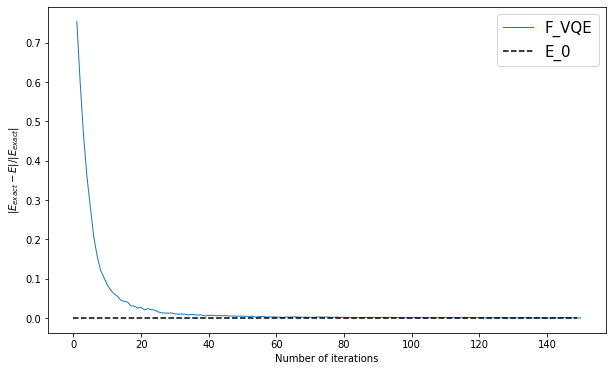

In [18]:
# A function to normalize the cost values
def normalize(list, exact):
    lis=[abs(exact-list[i])/abs(exact) for i in range(len(list))]
    return lis

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(fvqe_iter,normalize(fvqe_cost,E_min), linewidth=1, label='F_VQE')
plt.plot(range(0, 150), 0.0*np.ones(150), 'k--', linewidth=1.5, label='E_0')

plt.xlabel('Number of iterations')
plt.ylabel(r'$|E_{exact}-E|/|E_{exact}|$')
plt.legend(loc='upper right', fontsize=15)
plt.show()

As we can see, the Filtering VQE approach performs pretty well in finding the lowest energy of our Hamiltonian with a few number of iterations. I utilized the Filtering operator $c1-H$, which has the disadvantage of requiring the maximum eigenvalue of the Hamiltonian which with itself require a separate calculation using for instance the Subspace search VQE. However, there are other filtering operators which don't have this constraint and rely on a parameter $\tau$ to be dynamically updated after each iteration. To name one: the inverse Filtering operator $H^{-\tau}$ discussed in [this paper](https://www.nature.com/articles/s41534-019-0239-7). As mentioned this notebook will be updated with new filtering operators tested.

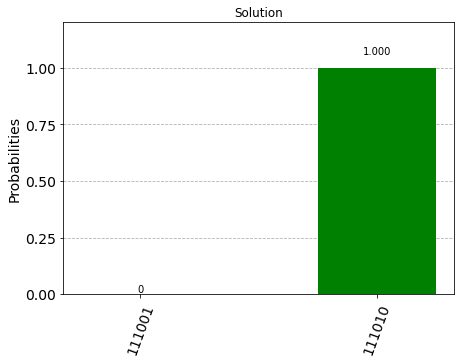

In [40]:
from qiskit.visualization import plot_histogram
counts=count(res.x,num_qubits,layers,2000)
plot_histogram(counts, color='green', title="Solution")

In [49]:
optimal_state=[eval(i) for i in max(counts, key=counts.get)]
print(optimal_state)

[1, 1, 1, 0, 1, 0]


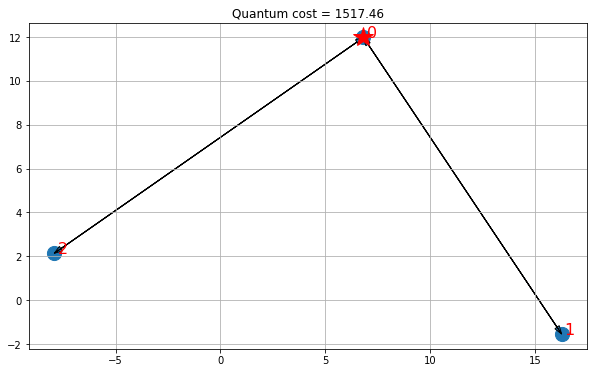

In [50]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=20)

    plt.grid()

    for ii in range(0, n**2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(
                xc[ix],
                yc[ix],
                xc[iy] - xc[ix],
                yc[iy] - yc[ix],
                length_includes_head=True,
                head_width=0.25,
            )

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()
#########################################################
# Initialize the problem by randomly generating the instance
initializer = Initializer(3,2)
xc, yc, instance = initializer.generate_instance()
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_quantum[ii] = optimal_state[kk]
        kk += 1


# visualize the solution
visualize_solution(xc, yc, x_quantum, E_min+offset, 3, 2, "Quantum")

# On real computer `ibm_Oslo`

In [ ]:
fvqe_cost, fvqe_iter=[],[]
def callback(nfevs, x_next, cost, stepsize):
    fvqe_cost.append(cost)
    fvqe_iter.append(nfevs)

num_qubits,layers,shots,c=H.num_qubits,1,5000,E_max+1
Filtering_op = c * (I^H.num_qubits) - H

theta= np.array([*((np.pi/2)*np.ones(num_qubits)),*(np.zeros(2*(num_qubits-1)*layers))])
optimizer = GradientDescent(maxiter=150,learning_rate=1.0,callback = callback)
obj=usual_expectation(num_qubits, layers, H, shots,hardware=True)

grad_fun=gradient(c, num_qubits, layers, Filtering_op, shots,hardware=True)
res=optimizer.minimize(fun=obj, x0=theta,jac=grad_fun)

print(res)
print()

# VQE solver
https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html

https://qiskit.org/documentation/tutorials/algorithms/04_vqe_advanced.html

In [34]:
from qiskit.algorithms import VQE, QAOA
from qiskit.circuit.library import TwoLocal

In [35]:
def gradient_vqe(tho,n,l,F_op,shots, hardware):
    def sub_gradient_vqe(thetas):
        list_gradient=[]
        dominator=2
        for j in range(len(thetas)):

            theta_n=np.array(thetas)
            theta_n[j]=theta_n[j]-np.pi/2
            theta_p=np.array(thetas)
            theta_p[j]=theta_p[j]+np.pi/2

            grad=((expectation(theta_p,n,l,H,shots,tho,False,False,hardware)-expectation(theta_n,n,l,H,shots,tho,False,False,hardware)))/dominator

            list_gradient.append(grad)
        return np.array(list_gradient)
    return sub_gradient_vqe

In [36]:
vqe_cost, vqe_iter=[],[]
def callback_vqe(nfevs, x_next, cost, stepsize):
    vqe_cost.append(cost)
    vqe_iter.append(nfevs)

In [37]:
qi = QuantumInstance(Aer.get_backend('qasm_simulator'), seed_transpiler=50, seed_simulator=50)
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
vqe=VQE(ansatz=ansatz, optimizer=optimizer, expectation=obj, callback=callback_vqe,quantum_instance=qi, gradient=gradient_vqe)#Ansatz(theta,num_qubits,layers),initial_point=theta
print(vqe)

In [38]:
result = vqe.compute_minimum_eigenvalue(operator=H)
print(result)

Traceback (most recent call last):
  Input In [38] in <cell line: 1>
    result = vqe.compute_minimum_eigenvalue(operator=H)
  File /opt/conda/lib/python3.8/site-packages/qiskit/algorithms/minimum_eigen_solvers/vqe.py:519 in compute_minimum_eigenvalue
    energy_evaluation, expectation = self.get_energy_evaluation(
  File /opt/conda/lib/python3.8/site-packages/qiskit/algorithms/minimum_eigen_solvers/vqe.py:594 in get_energy_evaluation
    expect_op, expectation = self.construct_expectation(
  File /opt/conda/lib/python3.8/site-packages/qiskit/algorithms/minimum_eigen_solvers/vqe.py:424 in construct_expectation
    observable_meas = expectation.convert(StateFn(operator, is_measurement=True))
AttributeError: 'function' object has no attribute 'convert'

Use %tb to get the full traceback.
